In [1]:
%matplotlib notebook

import tkinter
import matplotlib
import platform
if platform.system() not in ['Linux', 'Darwin'] and not platform.system().startswith('CYGWIN'):
    matplotlib.use('TKAgg')
import matplotlib.pyplot as plt
from IPython import display


#  寶可夢自動編碼器 (pytorch)

In [2]:
import glob
import os
import cv2
os.environ['TRIDENT_BACKEND'] = 'pytorch'
#!pip install tridentx --upgrade
import trident as T
from trident import *

Using Pytorch backend.
Image Data Format: channels_first.
Image Channel Order: bgr.
Pytorch version:1.3.1.
Pillow version:6.2.1.
Using pillow image backend.


In [3]:
dataset=T.load_examples_data('pokemon')

archive file is already existing, donnot need download again.
extraction is finished, donnot need extract again.
get pokemon images :1444
Mapping data  in train scenario  success, total 1444 record addeds.


In [4]:
dataset.image_transform_funcs=[resize((130,130)),
                               random_crop(128,128),
                               normalize(127.5,127.5)]       

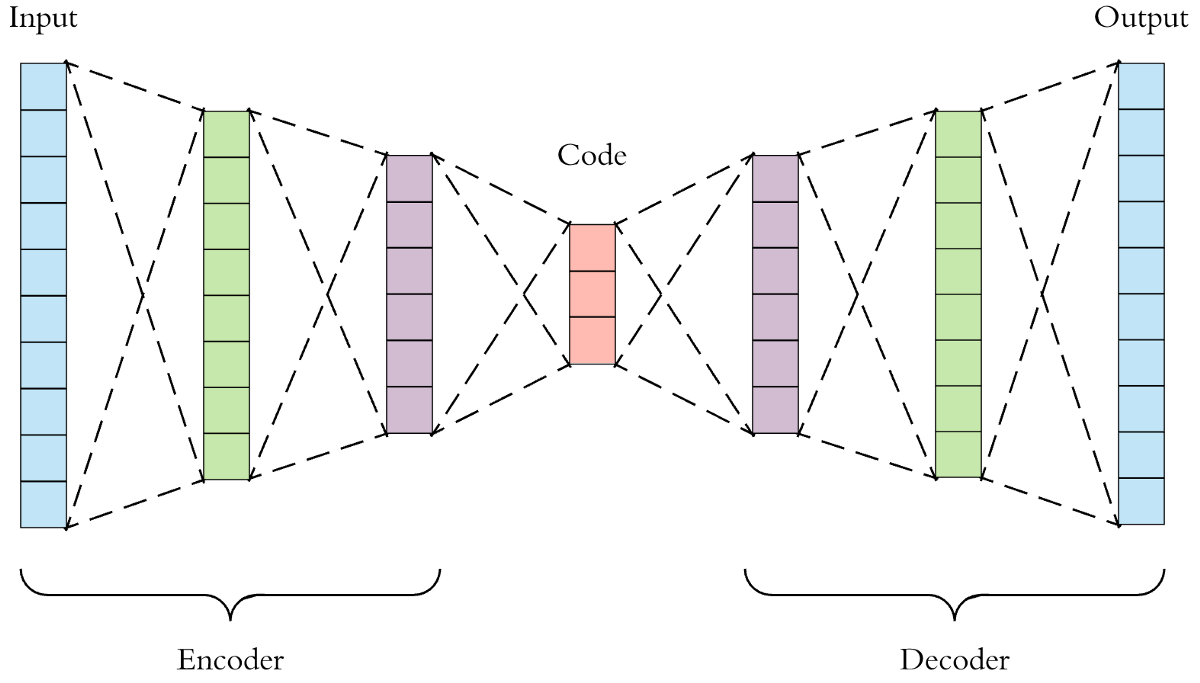

In [5]:
display.Image('../images/autoencoder.png',width=600)

In [6]:

encoder=Sequential(
    Conv2d_Block((5,5),32,strides=1,auto_pad=True,activation='leaky_relu',normalization='batch',use_bias=False, add_noise=True,noise_intensity=0.05),#(32,128,128)
    Conv2d_Block((3,3),64,strides=2,auto_pad=True,activation='leaky_relu',normalization='batch',use_bias=False),#(64,64,64)
    Conv2d_Block((3,3),64,strides=2,auto_pad=True,activation='leaky_relu',normalization='batch',use_bias=False),#(64,32,32)
    Conv2d_Block((3,3),128,strides=2,auto_pad=True,activation='leaky_relu',normalization='batch',use_bias=False,dropout_rate=0.5),#(128,16,16)
    Conv2d_Block((3,3),128,strides=2,auto_pad=True,activation='leaky_relu',normalization='batch',use_bias=False),#(128,8,8)
    Conv2d_Block((3,3),256,strides=2,auto_pad=True,activation='leaky_relu',normalization='batch',use_bias=False),#(256,4,4)
    Conv2d_Block((3,3),256,strides=1,auto_pad=True,activation='leaky_relu',normalization='batch',use_bias=False),#(256,4,4)
    Reshape((-1,1,1)), #(256*4*4)
    Conv2d((1,1),128,strides=1,auto_pad=True,activation='tanh',use_bias=False)
)


decoder=Sequential(
    Conv2d((1,1),128*4*4,strides=1,auto_pad=True,activation='tanh',use_bias=False), #(2048,1,1 )
    Reshape((128,4,4)), #(128,4,4))
    Conv2d_Block((3,3),128,strides=1,auto_pad=True,activation='leaky_relu',normalization='batch',use_bias=False) ,#((128,4,4))
    TransConv2d_Block((3,3),128,strides=2,auto_pad=True,activation='leaky_relu',normalization='batch',use_bias=False),#(128,8,8)
    TransConv2d_Block((3,3),64,strides=2,auto_pad=True,activation='leaky_relu',normalization='batch',use_bias=False),#(64,16,16)
    TransConv2d_Block((3,3),64,strides=2,auto_pad=True,activation='leaky_relu',normalization='batch',use_bias=False),#(64,32,32)
    TransConv2d_Block((3,3),64,strides=2,auto_pad=True,activation='leaky_relu',normalization='batch',use_bias=False),#(64,64,64)
    TransConv2d_Block((3,3),64,strides=2,auto_pad=True,activation='leaky_relu',normalization='batch',use_bias=False),#(64,128,128)
    Conv2d((1,1),3,strides=1,auto_pad=True,activation='tanh',use_bias=False)
)




In [7]:
autoencoder=Sequential(
    encoder,
    decoder
)

In [8]:
autoencoder.input_shape=[3,128,128]
summary(autoencoder,(3,128,128))
#如果你不想重頭跑，就請把下一行的註釋取消
#autoencoder=T.load('Models/pokemon_ae.pth')

--------------------------------------------------------------------------------------------------------------------------------
                            Layer (type)                   Output Shape                    Weight Shape      Bias Shape          Param #          FLOPS #
                                Conv2d-1             [-1, 32, 128, 128]                   [32, 3, 5, 5]                            2,400     78,626,816.0
                             BatchNorm-2             [-1, 32, 128, 128]                            [32]            [32]               64      1,556,480.0
                          Conv2d_Block-3             [-1, 32, 128, 128]                                                                0              0.0
                                Conv2d-4               [-1, 64, 64, 64]                  [64, 32, 3, 3]                           18,432    150,990,848.0
                             BatchNorm-5               [-1, 64, 64, 64]                            [6

In [9]:
model=Model(input_shape=[3,128,128],output=autoencoder)\  
    .with_optimizer(optimizer='Ranger',lr=2e-3,betas=(0.9, 0.999))\
    .with_loss(MSELoss,loss_weight=1,name='l2 loss')\
    .with_loss(EdgeLoss,loss_weight=0.2,name='edge loss')\
    .with_metric(rmse,name='rmse')\
    .with_regularizer('l2')\
    .with_learning_rate_scheduler(reduce_lr_on_plateau,mode='min',factor=0.75,patience=8,cooldown=2,threshold=5e-5,warmup=5)\
    .with_model_save_path('Models/pokemon_ae.pth')#存檔路徑設定

plan=TrainingPlan()\
    .add_training_item(model)\
    .with_data_loader(dataset)\
    .repeat_epochs(250)\
    .within_minibatch_size(32)\
    .print_progress_scheduling(20,unit='batch')\
    .save_model_scheduling(200,unit='batch')\  #這邊api有調整過，存檔路徑會改成在模型層級設定
    .display_tile_image_scheduling(1,'epoch','Results/','pokemon_ae_{0}.png',True,True,False,False,True)\



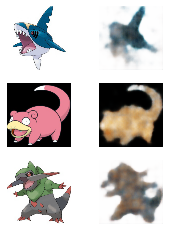

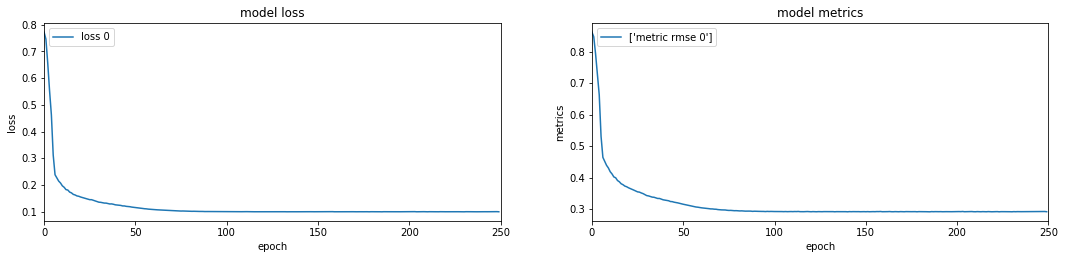

In [10]:
plan.start_now()

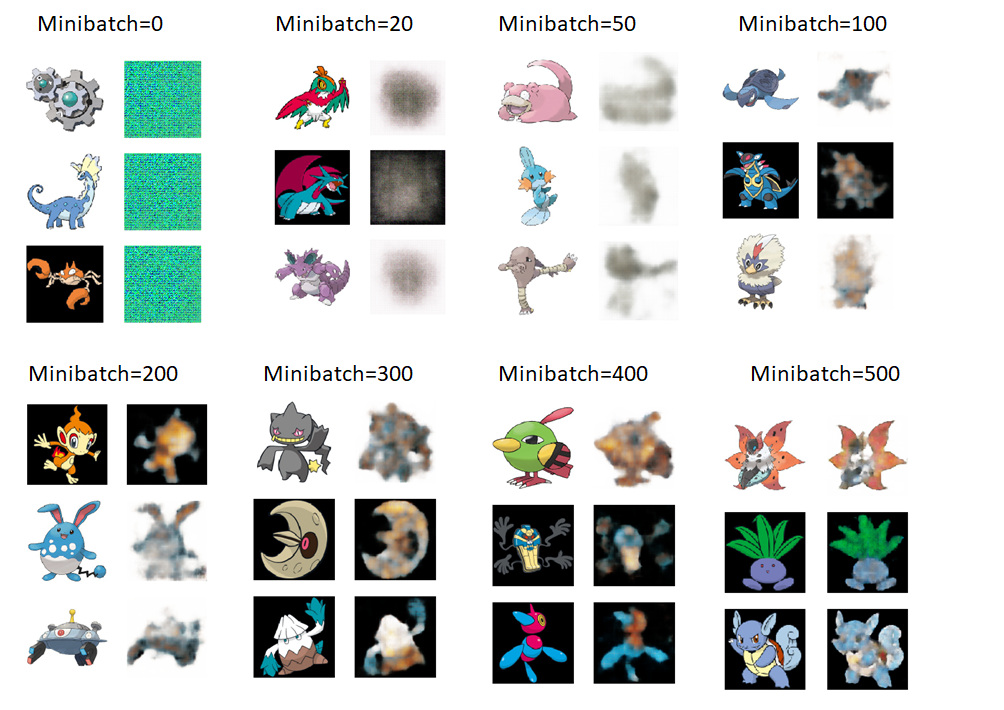

In [11]:
display.Image('../images/pokemon_training.png',width=800)

## 表徵學習 

In [12]:
features=[]


#dataset.data['train]
for img_data in dataset.get_all_data():
    input=to_tensor(np.expand_dims(dataset.image_transform(img_data),0))
    encoder_output = np.squeeze(to_numpy(autoencoder[0](input)))
    features.append(encoder_output)


features=np.asarray(features)
print(features.shape)
   

(1444, 128)


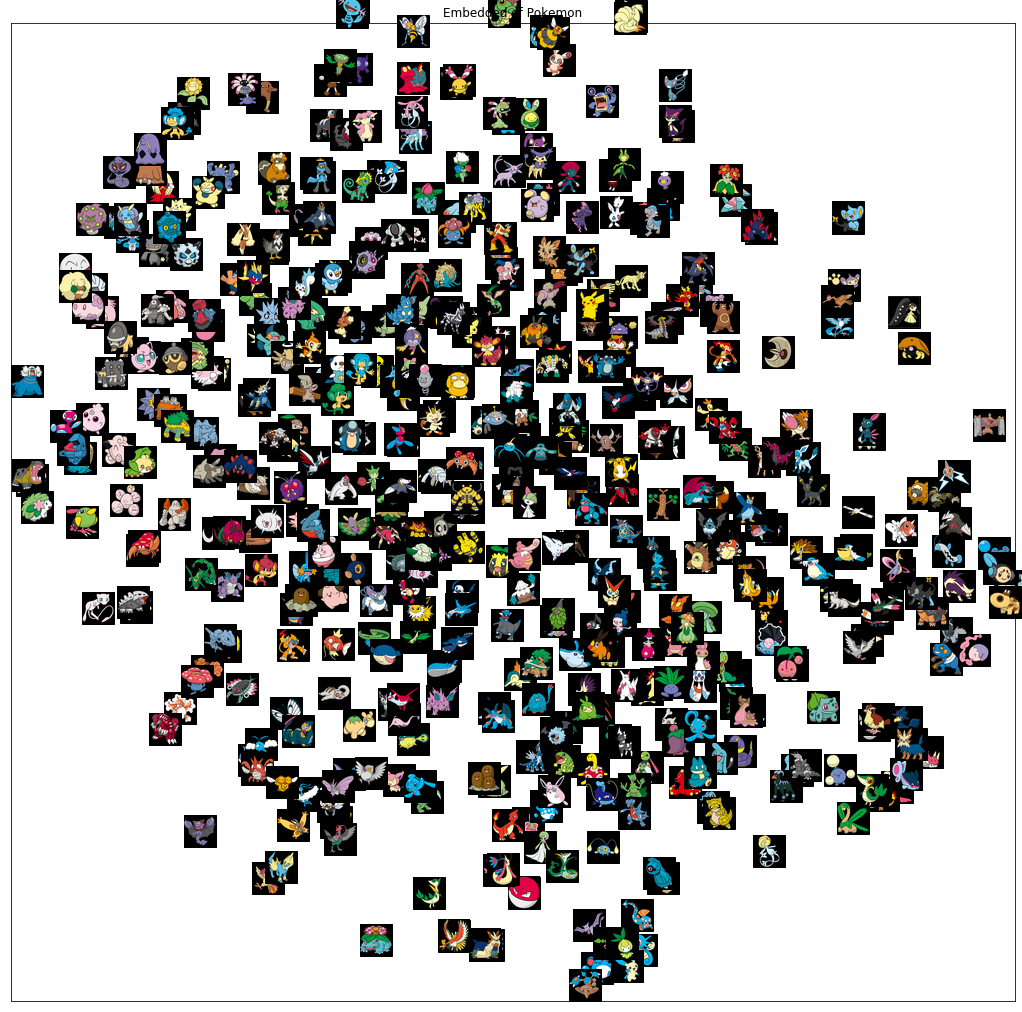

In [13]:
from matplotlib import offsetbox
from sklearn import manifold
import PIL
from PIL import Image as Image

def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    fig =plt.figure(figsize=(18,18))
    ax = plt.subplot(111)

    if hasattr(offsetbox, 'AnnotationBbox'):
        # 需要matplotlib 版本> 1.0才支援顯示圖片功能
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
           
            shown_images = np.r_[shown_images, [X[i]]]
            #將向量轉圖片，且將圖片縮小至32*32
            img=array2image(dataset.data['train'][i]) #array2image是 trident 內的函數
            img = img.resize((32, 32),Image.ANTIALIAS)
            imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(img),X[i],pad=0, box_alignment=(0, 0))
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
    display.display(fig)

#利用 t-SNE  降維
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)#利用t-sne將128特徵向量降維至2
X_tsne = tsne.fit_transform(features[:500,:])#為了避免圖片太密我只用了前500來處理

plot_embedding(X_tsne, "Embedded of Pokemon")#繪製圖像散布圖

## 寶可夢的相似性搜索 

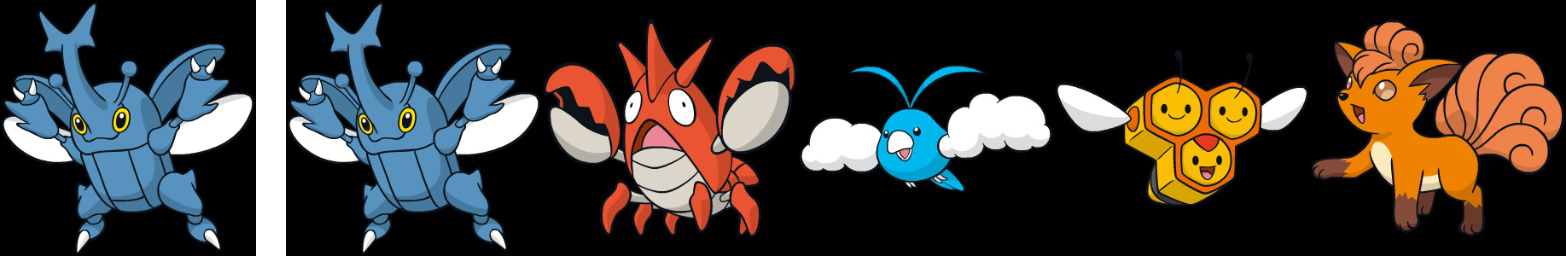

In [19]:
def find_similar_pokemon(idx):
    similarity_list=[]
    result=to_numpy(element_cosine_distance(features[idx:idx+1,:],features))  #element_cosine_distance逐成員計算Cosine距離


    top5=np.argsort(result)[-5:][::-1]  #找出前 5個Cosine距離最高者(Cosine距離是越高越像)
    similarity_list=[dataset.data['train'][idx]] #放入原圖
    similarity_list.append(np.ones_like(similarity_list[0])[:,:30,:]*255) # 加入白色分隔線
    similarity_list.extend(dataset.data['train'][top5]) #放入前 5名圖 

    merge_img=np.concatenate(similarity_list,axis=1) #沿著寬(axis=1)疊合
    display.display(array2image(merge_img)) #顯示結果



idx=128 #抽取一隻寶可夢
find_similar_pokemon(idx)

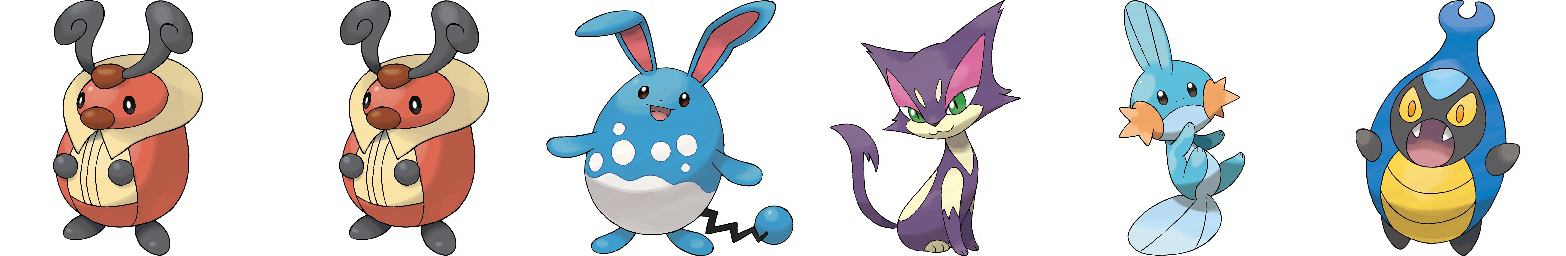

In [20]:
import random
find_similar_pokemon(random.choice(range(1444)))